In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
#from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
#from keras.layers.core import Dense, Dropout, Activation
#from keras.layers.recurrent import LSTM
from keras.layers import Dense, Dropout, Activation, LSTM
from keras.models import load_model
import keras
import h5py
import requests
import os

In [60]:
data_df =  pd.read_csv("d:/python/data-g/INFY.csv", index_col = 0)
data_df.head()

,symbol,open,close,low,high,volume
date,,,,,,
1/3/2000,INFOSYSTCH,15625.00,15625.20,15625.00,15625.20,5137
1/4/2000,INFOSYSTCH,16800.00,16855.90,16253.00,16875.25,56186
1/5/2000,INFOSYSTCH,15701.00,15507.45,15507.45,16250.00,164605
1/6/2000,INFOSYSTCH,15256.65,14266.85,14266.85,15300.00,81997
1/7/2000,INFOSYSTCH,13125.50,13125.50,13125.50,13125.50,7589


In [96]:
#df2 = pd.read_csv("d:/python/data-g/fundamentals.csv")
#df2.head()

In [61]:
data_df = data_df[data_df.symbol == 'INFOSYSTCH']
data_df.drop('symbol',axis='columns',inplace=True)
data_df.head()

,open,close,low,high,volume
date,,,,,
1/3/2000,15625.00,15625.20,15625.00,15625.20,5137
1/4/2000,16800.00,16855.90,16253.00,16875.25,56186
1/5/2000,15701.00,15507.45,15507.45,16250.00,164605
1/6/2000,15256.65,14266.85,14266.85,15300.00,81997
1/7/2000,13125.50,13125.50,13125.50,13125.50,7589


In [62]:
data_df.shape

(2871, 5)

In [63]:
data_df.tail()

,open,close,low,high,volume
date,,,,,
6/22/2011,2753.00,2755.05,2742.10,2781.70,703125
6/23/2011,2750.00,2779.10,2735.50,2789.10,519846
6/24/2011,2791.00,2859.95,2791.00,2877.70,1402411
6/27/2011,2831.65,2871.05,2820.25,2923.00,1340537
6/28/2011,2870.05,2865.30,2843.80,2876.85,560849


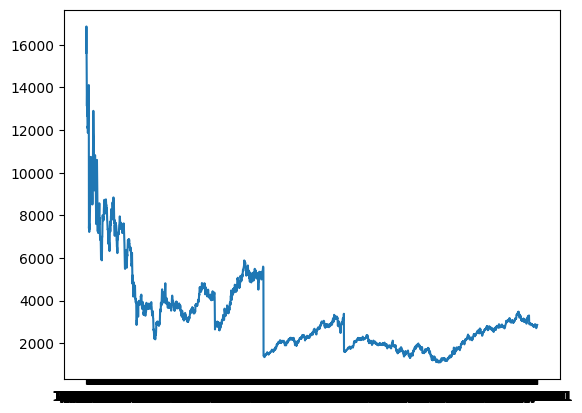

In [65]:
plt.plot(data_df['close'])
plt.show()

In [66]:
data_df['date'] = data_df.index
data_df.head()

,open,close,low,high,volume,date
date,,,,,,
1/3/2000,15625.00,15625.20,15625.00,15625.20,5137,1/3/2000
1/4/2000,16800.00,16855.90,16253.00,16875.25,56186,1/4/2000
1/5/2000,15701.00,15507.45,15507.45,16250.00,164605,1/5/2000
1/6/2000,15256.65,14266.85,14266.85,15300.00,81997,1/6/2000
1/7/2000,13125.50,13125.50,13125.50,13125.50,7589,1/7/2000


In [67]:
data_df['date'] = pd.to_datetime(data_df['date'])

In [69]:
data_df.head()

,open,close,low,high,volume,date
date,,,,,,
1/3/2000,15625.00,15625.20,15625.00,15625.20,5137,2000-01-03
1/4/2000,16800.00,16855.90,16253.00,16875.25,56186,2000-01-04
1/5/2000,15701.00,15507.45,15507.45,16250.00,164605,2000-01-05
1/6/2000,15256.65,14266.85,14266.85,15300.00,81997,2000-01-06
1/7/2000,13125.50,13125.50,13125.50,13125.50,7589,2000-01-07


In [70]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
dataset = min_max_scaler.fit_transform(data_df['close'].values.reshape(-1, 1))

In [71]:
dataset[0:10]

array([[0.92187817],
       [1.        ],
       [0.91440369],
       [0.83565344],
       [0.76320333],
       [0.80330845],
       [0.73344823],
       [0.76015958],
       [0.69751041],
       [0.70295678]])

In [83]:
# split into train and test sets
train_size = int(len(dataset) * 0.6)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

1722 1149


In [84]:
print(len(data_df))
print(1722 + 1149)

2871
2871


In [85]:
def create_dataset(dataset, look_back=15):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [86]:
x_train, y_train = create_dataset(train, look_back=15)
x_test, y_test = create_dataset(test, look_back=15)

In [87]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1706, 15)
(1706,)
(1133, 15)
(1133,)


In [88]:
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

In [89]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1706, 1, 15)
(1706,)
(1133, 1, 15)
(1133,)


In [93]:
# create and fit the LSTM network
look_back = 15
model = Sequential()
model.add(LSTM(20, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='lion')
model.fit(x_train, y_train, epochs=20, batch_size=1, verbose=2)

Epoch 1/20


C:\Users\kalyan\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1706/1706 - 3s - 2ms/step - loss: 0.0014
Epoch 2/20
1706/1706 - 2s - 996us/step - loss: 4.6124e-04
Epoch 3/20
1706/1706 - 2s - 1ms/step - loss: 4.2164e-04
Epoch 4/20
1706/1706 - 2s - 997us/step - loss: 4.2739e-04
Epoch 5/20
1706/1706 - 2s - 1ms/step - loss: 3.9014e-04
Epoch 6/20
1706/1706 - 2s - 987us/step - loss: 3.9002e-04
Epoch 7/20
1706/1706 - 2s - 1ms/step - loss: 4.0644e-04
Epoch 8/20
1706/1706 - 2s - 1ms/step - loss: 3.6791e-04
Epoch 9/20
1706/1706 - 2s - 1ms/step - loss: 3.4394e-04
Epoch 10/20
1706/1706 - 2s - 1ms/step - loss: 3.8105e-04
Epoch 11/20
1706/1706 - 2s - 1ms/step - loss: 3.2311e-04
Epoch 12/20
1706/1706 - 2s - 1ms/step - loss: 3.4204e-04
Epoch 13/20
1706/1706 - 2s - 1ms/step - loss: 3.5432e-04
Epoch 14/20
1706/1706 - 2s - 990us/step - loss: 3.7624e-04
Epoch 15/20
1706/1706 - 2s - 1ms/step - loss: 3.6806e-04
Epoch 16/20
1706/1706 - 2s - 1ms/step - loss: 3.4582e-04
Epoch 17/20
1706/1706 - 2s - 1ms/step - loss: 3.2276e-04
Epoch 18/20
1706/1706 - 2s - 1ms/step - loss: 3

In [94]:
trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)
# invert predictions
trainPredict = min_max_scaler.inverse_transform(trainPredict)
trainY = min_max_scaler.inverse_transform([y_train])
testPredict = min_max_scaler.inverse_transform(testPredict)
testY = min_max_scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Train Score: 255.03 RMSE
Test Score: 126.27 RMSE


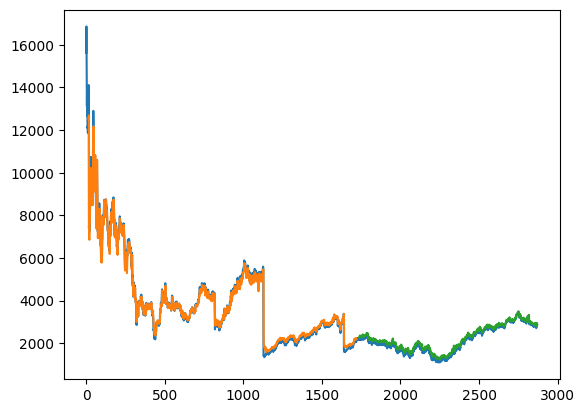

In [95]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(min_max_scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()